Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# For this to work, use:
# Keras 2.3.1
# TensorFlow 1.15.2
# Also remember to use GPU in your colab notebook
%tensorflow_version 1.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 14.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 16.1 MB/s 
     |████████████████████████████████| 6.6 MB 78.2 MB/s 
     |████████████████████████████████| 101 kB 10.5 MB/s 
     |████████████████████████████████| 596 kB 67.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=046e5a069bd5650502b4b5f02440e9eb17a50e25eaa4baebd2e461e9f5a21093
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [2]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1Y2gfhNgbGX7pA0FkA2vbOxdoSmNJVHIK'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1AGW9cRPwBmeJqOo3WXPPcNckrX4jMcIn'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1L-fnx31bK0nZAl9_DDfo7-25H7PYU0l8'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [3]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  13052
Number of dev sentences:  3263
Number of test sentences:  27625
Number of words in the training dataset:  13860
Number of words in the dev dataset:  6360
Number of words in the test dataset:  21696
Tags in the training dataset: ['I-problem', 'I-test', 'B-treatment', 'O', 'I-treatment', 'B-test', 'B-problem']
Number of Labels in the training dataset:  7
Tags in the dev dataset: ['I-problem', 'I-test', 'B-treatment', 'O', 'I-treatment', 'B-test', 'B-problem']
Number of Labels in the dev dataset:  7
Tags in the test dataset: ['I-problem', 'I-test', 'B-treatment', 'O', 'I-treatment', 'B-test', 'B-problem']
Number of Labels in the test dataset:  7
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 10707,She,O
1,Sentence: 10707,had,O
2,Sentence: 10707,normal,O
3,Sentence: 10707,comprehension,O
4,Sentence: 10707,.,O
5,Sentence: 7349,Scott,O
6,Sentence: 7349,Robert,O
7,Sentence: 7349,NP,O
8,Sentence: 7349,80-AUM,O
9,Sentence: 7349,2017-06-29,O


In [4]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Last', 'O'),
 ('menstrual', 'O'),
 ('period', 'O'),
 ('2009-02-21', 'O'),
 ('.', 'O')]

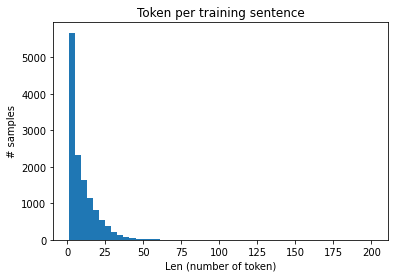

In [5]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

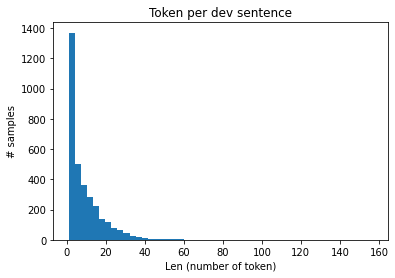

In [6]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

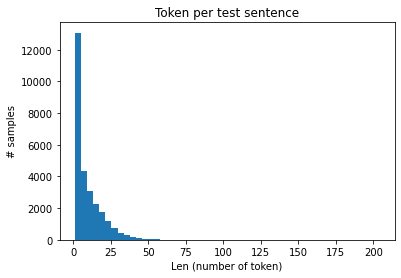

In [7]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [8]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'comprehension'
print(word2idx['comprehension'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-treatment'
print(tag2idx['B-treatment'])
# Tag of index 4
print(idx2tag[4])

25857
2809
2
I-treatment


In [9]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [10]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.9885)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 13052
Points in y_train before removal: 13052
Points in X_train before removal: 150
Points in y_train before removal: 150


In [11]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [12]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[17561, 15793]
[3, 3]
[20440, 7159, 26173, 22273, 16536, 26222, 11711, 24350, 20359, 4869, 17508, 5464, 25374, 9496]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[11272, 16992, 15793]
[3, 3, 3]
25857
2
B-treatment
FINGER
28388
7


In [13]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 1.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1YWR4Ip8w94RwFMyMtNpRa9M0FpiJtqd5'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.fillna(method="ffill")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['comprehension'])
print(tag2idx['B-treatment'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[17561, 15793]
[3, 3]
[20440, 7159, 26173, 22273, 16536, 26222, 11711, 24350, 20359, 4869, 17508, 5464, 25374, 9496]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[11272, 16992, 15793]
[3, 3, 3]
25857
2
B-treatment
FINGER
28388
7


In [14]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [15]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [16]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

In [17]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 64:
    TRAIN_BATCH_SIZE = 64
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 64:
    VALID_BATCH_SIZE = 64
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [18]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [19]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [20]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [' '.join([idx2word[word] for word in sentence]) for sentence in augmented_X_train]
  X_dev_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_dev]
  X_test_words = [' '.join([idx2word[word] for word in sentence]) for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [21]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7646105289459229
Training loss epoch: 0.9380846440792083
Training accuracy epoch: 0.74
Validating model...
Validation Loss: 0.41669100756738703
Validation Accuracy: 0.8626964674758792
Training epoch: 2
Training loss per 100 training steps: 0.34624773263931274
Training loss epoch: 0.2803040397663911
Training accuracy epoch: 0.9066666666666666
Validating model...
Validation Loss: 0.3176391034149656
Validation Accuracy: 0.9077380952380952
Training epoch: 3
Training loss per 100 training steps: 0.08645381778478622
Training loss epoch: 0.0657230400169889
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.31919530662251455
Validation Accuracy: 0.911735527544351
Training epoch: 4
Training loss per 100 training steps: 0.01148003339767456
Training loss epoch: 0.012646550980086128
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.34660109775323494
Validation Accuracy: 0.908370292561469
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.31430682074278593
Validation Accuracy: 0.9110675318992774
Validation duration: 2.1515257833333328 minutes
F1-score (test): 68.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.63      0.42      0.50      1170
        test       0.79      0.72      0.76      2464
   treatment       0.80      0.64      0.71      1244

   micro avg       0.76      0.63      0.69      4878
   macro avg       0.74      0.59      0.66      4878
weighted avg       0.75      0.63      0.68      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.205043315887451
Training loss epoch: 0.8691897849241893
Training accuracy epoch: 0.74
Validating model...
Validation Loss: 0.449918668644101
Validation Accuracy: 0.8642283302209773
Training epoch: 2
Training loss per 100 training steps: 0.3721570074558258
Training loss epoch: 0.32784806142250694
Training accuracy epoch: 0.8733333333333334
Validating model...
Validation Loss: 0.36030223381285575
Validation Accuracy: 0.8936546840958605
Training epoch: 3
Training loss per 100 training steps: 0.07230602949857712
Training loss epoch: 0.06929428987205029
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.40656671716886406
Validation Accuracy: 0.8970247821350762
Training epoch: 4
Training loss per 100 training steps: 0.014526556245982647
Training loss epoch: 0.018204661707083385
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.34569542533626746
Validation Accuracy: 0.9055934873949579
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.377131007766972
Validation Accuracy: 0.9017721036585366
Validation duration: 2.071111033333333 minutes
F1-score (test): 66.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.67      0.42      0.51      1170
        test       0.63      0.84      0.72      2464
   treatment       0.94      0.46      0.62      1244

   micro avg       0.68      0.64      0.66      4878
   macro avg       0.75      0.57      0.62      4878
weighted avg       0.72      0.64      0.65      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.7937979698181152
Training loss epoch: 1.0500172555446625
Training accuracy epoch: 0.7200000000000002
Validating model...
Validation Loss: 0.4587537465142269
Validation Accuracy: 0.8455639200124494
Training epoch: 2
Training loss per 100 training steps: 0.376804918050766
Training loss epoch: 0.32621168345212936
Training accuracy epoch: 0.8866666666666667
Validating model...
Validation Loss: 0.38818708792621015
Validation Accuracy: 0.8847893323996264
Training epoch: 3
Training loss per 100 training steps: 0.09462711215019226
Training loss epoch: 0.09449804251392682
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.31193046038057287
Validation Accuracy: 0.9080590569561158
Training epoch: 4
Training loss per 100 training steps: 0.011204229667782784
Training loss epoch: 0.016662134261180957
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.3196338562696588
Validation Accuracy: 0.9117306644880173
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.32523085412362385
Validation Accuracy: 0.9029092211495032
Validation duration: 2.0591225500000006 minutes
F1-score (test): 63.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.71      0.21      0.33      1170
        test       0.87      0.60      0.71      2464
   treatment       0.79      0.61      0.69      1244

   micro avg       0.83      0.51      0.63      4878
   macro avg       0.79      0.48      0.58      4878
weighted avg       0.81      0.51      0.62      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9540777206420898
Training loss epoch: 0.8181957681973775
Training accuracy epoch: 0.7533333333333335
Validating model...
Validation Loss: 0.45857541233885524
Validation Accuracy: 0.8682160364145658
Training epoch: 2
Training loss per 100 training steps: 0.47189798951148987
Training loss epoch: 0.22489810523887474
Training accuracy epoch: 0.9466666666666668
Validating model...
Validation Loss: 0.35629016979067935
Validation Accuracy: 0.8957895658263305
Training epoch: 3
Training loss per 100 training steps: 0.09023895859718323
Training loss epoch: 0.03757119420915842
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.31182487104453294
Validation Accuracy: 0.9138655462184874
Training epoch: 4
Training loss per 100 training steps: 0.007222222629934549
Training loss epoch: 0.01782932348238925
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.43578431945221097
Validation Accuracy: 0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3269282694543815
Validation Accuracy: 0.9056104265469739
Validation duration: 2.061424550000002 minutes
F1-score (test): 68.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.52      0.56      0.54      1170
        test       0.73      0.79      0.76      2464
   treatment       0.88      0.55      0.68      1244

   micro avg       0.70      0.68      0.69      4878
   macro avg       0.71      0.64      0.66      4878
weighted avg       0.72      0.68      0.69      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.684927225112915
Training loss epoch: 0.8668236802021663
Training accuracy epoch: 0.7466666666666666
Validating model...
Validation Loss: 0.5242281871683457
Validation Accuracy: 0.8664021164021164
Training epoch: 2
Training loss per 100 training steps: 0.34876734018325806
Training loss epoch: 0.33095248192548754
Training accuracy epoch: 0.8933333333333334
Validating model...
Validation Loss: 0.36783280968666077
Validation Accuracy: 0.8850859788359787
Training epoch: 3
Training loss per 100 training steps: 0.1525198221206665
Training loss epoch: 0.11082381283243498
Training accuracy epoch: 0.9866666666666667
Validating model...
Validation Loss: 0.43871688521375846
Validation Accuracy: 0.8734486850295674
Training epoch: 4
Training loss per 100 training steps: 0.05612781643867493
Training loss epoch: 0.030784459474186104
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4276004144374062
Validation Accuracy: 0.88631

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3690831059572735
Validation Accuracy: 0.8979179017050588
Validation duration: 2.1029506166666656 minutes
F1-score (test): 60.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.51      0.33      0.40      1170
        test       0.85      0.67      0.75      2464
   treatment       0.90      0.31      0.46      1244

   micro avg       0.78      0.50      0.61      4878
   macro avg       0.75      0.44      0.54      4878
weighted avg       0.78      0.50      0.59      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.945439100265503
Training loss epoch: 0.9629676083723704
Training accuracy epoch: 0.7600000000000001
Validating model...
Validation Loss: 0.5329088101200029
Validation Accuracy: 0.8556742141300964
Training epoch: 2
Training loss per 100 training steps: 0.5126985311508179
Training loss epoch: 0.3887720892826716
Training accuracy epoch: 0.8466666666666669
Validating model...
Validation Loss: 0.39604848418750016
Validation Accuracy: 0.8688093292872704
Training epoch: 3
Training loss per 100 training steps: 0.05379289388656616
Training loss epoch: 0.14878385178744793
Training accuracy epoch: 0.9600000000000002
Validating model...
Validation Loss: 0.3658473257924996
Validation Accuracy: 0.8896767040149394
Training epoch: 4
Training loss per 100 training steps: 0.01426697801798582
Training loss epoch: 0.047605977455774946
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.4028395233201046
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3792166166455933
Validation Accuracy: 0.8892620469173442
Validation duration: 2.103946266666666 minutes
F1-score (test): 57.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.59      0.26      0.36      1170
        test       0.82      0.59      0.69      2464
   treatment       0.69      0.39      0.50      1244

   micro avg       0.75      0.46      0.57      4878
   macro avg       0.70      0.41      0.52      4878
weighted avg       0.73      0.46      0.56      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.268580436706543
Training loss epoch: 0.7663035829861958
Training accuracy epoch: 0.7533333333333334
Validating model...
Validation Loss: 0.41785168764637964
Validation Accuracy: 0.8706718798630564
Training epoch: 2
Training loss per 100 training steps: 0.32922130823135376
Training loss epoch: 0.28622333804766337
Training accuracy epoch: 0.9266666666666669
Validating model...
Validation Loss: 0.319242215331863
Validation Accuracy: 0.9010076252723311
Training epoch: 3
Training loss per 100 training steps: 0.028070766478776932
Training loss epoch: 0.05534695386886597
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.34385354670823787
Validation Accuracy: 0.8997675459072518
Training epoch: 4
Training loss per 100 training steps: 0.04617265611886978
Training loss epoch: 0.01475208488603433
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.32844657480132344
Validation Accuracy: 0.9046889589169002
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3296253716711093
Validation Accuracy: 0.8976170816395664
Validation duration: 2.061007683333336 minutes
F1-score (test): 65.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.59      0.47      0.52      1170
        test       0.71      0.76      0.74      2464
   treatment       0.68      0.49      0.57      1244

   micro avg       0.68      0.62      0.65      4878
   macro avg       0.66      0.57      0.61      4878
weighted avg       0.68      0.62      0.64      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6031372547149658
Training loss epoch: 0.7880534519751866
Training accuracy epoch: 0.7533333333333333
Validating model...
Validation Loss: 0.4046688298968708
Validation Accuracy: 0.8642380563336446
Training epoch: 2
Training loss per 100 training steps: 0.5847084522247314
Training loss epoch: 0.2098703093826771
Training accuracy epoch: 0.9400000000000001
Validating model...
Validation Loss: 0.31832337817725015
Validation Accuracy: 0.9037844304388422
Training epoch: 3
Training loss per 100 training steps: 0.03444547578692436
Training loss epoch: 0.0449816074843208
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.32035402398483426
Validation Accuracy: 0.9010222144413321
Training epoch: 4
Training loss per 100 training steps: 0.013079116120934486
Training loss epoch: 0.028802984052648146
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.39859282473723096
Validation Accuracy: 0.8967

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.33329149835777505
Validation Accuracy: 0.9016635967140921
Validation duration: 2.0534606333333385 minutes
F1-score (test): 62.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.53      0.40      0.46      1170
        test       0.84      0.62      0.71      2464
   treatment       0.80      0.49      0.61      1244

   micro avg       0.75      0.54      0.63      4878
   macro avg       0.72      0.50      0.59      4878
weighted avg       0.75      0.54      0.63      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.039065361022949
Training loss epoch: 0.8180105417966843
Training accuracy epoch: 0.76
Validating model...
Validation Loss: 0.4511631379524867
Validation Accuracy: 0.8470568783068783
Training epoch: 2
Training loss per 100 training steps: 0.12291858345270157
Training loss epoch: 0.2539488698045413
Training accuracy epoch: 0.9333333333333333
Validating model...
Validation Loss: 0.33190203078237235
Validation Accuracy: 0.8954783302209773
Training epoch: 3
Training loss per 100 training steps: 0.10019984096288681
Training loss epoch: 0.0787096705287695
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.36747805598904104
Validation Accuracy: 0.9013091347650172
Training epoch: 4
Training loss per 100 training steps: 0.009837866760790348
Training loss epoch: 0.018701556945840518
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.3866701004844086
Validation Accuracy: 0.893032212885154
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.334128401035236
Validation Accuracy: 0.8917330058717254
Validation duration: 2.0917998499999992 minutes
F1-score (test): 59.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.83      0.21      0.33      1170
        test       0.69      0.67      0.68      2464
   treatment       0.68      0.48      0.56      1244

   micro avg       0.70      0.51      0.59      4878
   macro avg       0.73      0.45      0.53      4878
weighted avg       0.72      0.51      0.57      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.771203637123108
Training loss epoch: 0.8908191879590353
Training accuracy epoch: 0.7533333333333335
Validating model...
Validation Loss: 0.661177866599139
Validation Accuracy: 0.8329783302209773
Training epoch: 2
Training loss per 100 training steps: 0.4702181816101074
Training loss epoch: 0.6153137107690175
Training accuracy epoch: 0.8266666666666667
Validating model...
Validation Loss: 0.43644488909665274
Validation Accuracy: 0.8630077030812324
Training epoch: 3
Training loss per 100 training steps: 0.2054840624332428
Training loss epoch: 0.30319457898537316
Training accuracy epoch: 0.9066666666666667
Validating model...
Validation Loss: 0.4580423799799938
Validation Accuracy: 0.8746498599439775
Training epoch: 4
Training loss per 100 training steps: 0.07546751201152802
Training loss epoch: 0.13436018464465935
Training accuracy epoch: 0.9533333333333334
Validating model...
Validation Loss: 0.33533189168163374
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.34428316146066346
Validation Accuracy: 0.8878920364724481
Validation duration: 2.0877906833333326 minutes
F1-score (test): 63.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.36      0.72      0.48      1170
        test       0.83      0.67      0.74      2464
   treatment       0.82      0.54      0.65      1244

   micro avg       0.61      0.65      0.63      4878
   macro avg       0.67      0.64      0.62      4878
weighted avg       0.71      0.65      0.65      4878



In [22]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9781858921051025
Training loss epoch: 0.9272391623572299
Training accuracy epoch: 0.7434210526315791
Validating model...
Validation Loss: 0.4787065491956823
Validation Accuracy: 0.8455736461251167
Training epoch: 2
Training loss per 100 training steps: 0.13422806560993195
Training loss epoch: 0.32681295197261007
Training accuracy epoch: 0.8763157894736845
Validating model...
Validation Loss: 0.3804514942800297
Validation Accuracy: 0.8676227435418611
Training epoch: 3
Training loss per 100 training steps: 0.1227610856294632
Training loss epoch: 0.110788592872651
Training accuracy epoch: 0.9776315789473684
Validating model...
Validation Loss: 0.4392939469977921
Validation Accuracy: 0.8817012916277622
Training epoch: 4
Training loss per 100 training steps: 0.023705901578068733
Training loss epoch: 0.02989892690981689
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.3870734829528659
Validation Accuracy: 0.89059095

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3931494602864539
Validation Accuracy: 0.861109346770551
Validation duration: 2.0559089166666658 minutes
F1-score (test): 43.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.50      0.05      0.09      1170
        test       0.50      0.52      0.51      2464
   treatment       0.67      0.38      0.48      1244

   micro avg       0.53      0.37      0.44      4878
   macro avg       0.56      0.31      0.36      4878
weighted avg       0.54      0.37      0.40      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.02504301071167
Training loss epoch: 0.730343430842224
Training accuracy epoch: 0.788157894736842
Validating model...
Validation Loss: 0.4360326768136492
Validation Accuracy: 0.8415616246498598
Training epoch: 2
Training loss per 100 training steps: 0.41011208295822144
Training loss epoch: 0.28146792781588276
Training accuracy epoch: 0.8947368421052632
Validating model...
Validation Loss: 0.3830330964981341
Validation Accuracy: 0.8856841347650172
Training epoch: 3
Training loss per 100 training steps: 0.027641406282782555
Training loss epoch: 0.09718123396956607
Training accuracy epoch: 0.9789473684210527
Validating model...
Validation Loss: 0.33178148170312244
Validation Accuracy: 0.8985760971055088
Training epoch: 4
Training loss per 100 training steps: 0.020048465579748154
Training loss epoch: 0.032750283907118594
Training accuracy epoch: 0.9894736842105264
Validating model...
Validation Loss: 0.3722663074731827
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3445915637054929
Validation Accuracy: 0.9037455185749773
Validation duration: 2.068761299999998 minutes
F1-score (test): 68.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.59      0.58      0.58      1170
        test       0.71      0.78      0.74      2464
   treatment       0.79      0.54      0.64      1244

   micro avg       0.70      0.67      0.68      4878
   macro avg       0.70      0.63      0.66      4878
weighted avg       0.70      0.67      0.68      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0793614387512207
Training loss epoch: 0.7641405980837973
Training accuracy epoch: 0.7868421052631579
Validating model...
Validation Loss: 0.39449262648236516
Validation Accuracy: 0.8636107220666044
Training epoch: 2
Training loss per 100 training steps: 0.11052712053060532
Training loss epoch: 0.18174253747259317
Training accuracy epoch: 0.9565789473684211
Validating model...
Validation Loss: 0.3925364959765883
Validation Accuracy: 0.8951914098972923
Training epoch: 3
Training loss per 100 training steps: 0.03341038152575493
Training loss epoch: 0.05186599978294812
Training accuracy epoch: 0.9894736842105264
Validating model...
Validation Loss: 0.3301779630721784
Validation Accuracy: 0.9003997432306255
Training epoch: 4
Training loss per 100 training steps: 0.019436951726675034
Training loss epoch: 0.018481275495631916
Training accuracy epoch: 0.994736842105263
Validating model...
Validation Loss: 0.3316175996088514
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3360266925215169
Validation Accuracy: 0.9030221389453478
Validation duration: 2.0688983166666657 minutes
F1-score (test): 64.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.35      0.47      1170
        test       0.86      0.60      0.70      2464
   treatment       0.78      0.59      0.67      1244

   micro avg       0.81      0.54      0.65      4878
   macro avg       0.79      0.51      0.62      4878
weighted avg       0.81      0.54      0.64      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.19405198097229
Training loss epoch: 0.8183996277420145
Training accuracy epoch: 0.7710526315789474
Validating model...
Validation Loss: 0.4286908966069128
Validation Accuracy: 0.8614855664488017
Training epoch: 2
Training loss per 100 training steps: 0.34592384099960327
Training loss epoch: 0.2440709079566755
Training accuracy epoch: 0.9249999999999999
Validating model...
Validation Loss: 0.30693111378772586
Validation Accuracy: 0.9028458605664488
Training epoch: 3
Training loss per 100 training steps: 0.032890163362026215
Training loss epoch: 0.05530909736836819
Training accuracy epoch: 0.9894736842105264
Validating model...
Validation Loss: 0.4010717665740088
Validation Accuracy: 0.8985712340491753
Training epoch: 4
Training loss per 100 training steps: 0.015280966646969318
Training loss epoch: 0.012340171887588344
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.3089379471014528
Validation Accuracy: 0.91327

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.32079285764376875
Validation Accuracy: 0.8968690012420958
Validation duration: 2.0706805666666694 minutes
F1-score (test): 62.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.70      0.31      0.43      1170
        test       0.62      0.79      0.69      2464
   treatment       0.89      0.47      0.61      1244

   micro avg       0.67      0.59      0.63      4878
   macro avg       0.73      0.52      0.58      4878
weighted avg       0.71      0.59      0.61      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9308620691299438
Training loss epoch: 0.9118476619845942
Training accuracy epoch: 0.755263157894737
Validating model...
Validation Loss: 0.6320237149210537
Validation Accuracy: 0.8329783302209773
Training epoch: 2
Training loss per 100 training steps: 0.4118350148200989
Training loss epoch: 0.6529099760871184
Training accuracy epoch: 0.8078947368421053
Validating model...
Validation Loss: 0.5481563946780037
Validation Accuracy: 0.8333041549953315
Training epoch: 3
Training loss per 100 training steps: 0.1931764781475067
Training loss epoch: 0.4017630509640041
Training accuracy epoch: 0.8723684210526316
Validating model...
Validation Loss: 0.40325043832554536
Validation Accuracy: 0.868225762527233
Training epoch: 4
Training loss per 100 training steps: 0.24822430312633514
Training loss epoch: 0.08001216672556966
Training accuracy epoch: 0.9842105263157896
Validating model...
Validation Loss: 0.3445188059818511
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.35470538689858383
Validation Accuracy: 0.9047017911585366
Validation duration: 2.0767507000000025 minutes
F1-score (test): 65.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.76      0.39      0.52      1170
        test       0.72      0.74      0.73      2464
   treatment       0.94      0.43      0.59      1244

   micro avg       0.76      0.58      0.66      4878
   macro avg       0.81      0.52      0.61      4878
weighted avg       0.79      0.58      0.64      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.848793387413025
Training loss epoch: 0.9367639030280867
Training accuracy epoch: 0.7197368421052632
Validating model...
Validation Loss: 0.4401636585301044
Validation Accuracy: 0.8430983504512917
Training epoch: 2
Training loss per 100 training steps: 0.7288298606872559
Training loss epoch: 0.26793900955664485
Training accuracy epoch: 0.9157894736842106
Validating model...
Validation Loss: 0.3699302927536123
Validation Accuracy: 0.8850859788359787
Training epoch: 3
Training loss per 100 training steps: 0.6527757048606873
Training loss epoch: 0.07934928371718056
Training accuracy epoch: 0.9894736842105264
Validating model...
Validation Loss: 0.38494524812581493
Validation Accuracy: 0.8967281356987239
Training epoch: 4
Training loss per 100 training steps: 0.01006920263171196
Training loss epoch: 0.026497654126662957
Training accuracy epoch: 0.988157894736842
Validating model...
Validation Loss: 0.3440851963618222
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.34866827489221813
Validation Accuracy: 0.8985574751580849
Validation duration: 2.0719108666666597 minutes
F1-score (test): 67.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.51      0.68      0.58      1170
        test       0.72      0.76      0.74      2464
   treatment       0.73      0.58      0.64      1244

   micro avg       0.66      0.69      0.67      4878
   macro avg       0.65      0.67      0.65      4878
weighted avg       0.67      0.69      0.68      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.043393611907959
Training loss epoch: 0.8180470639153531
Training accuracy epoch: 0.7342105263157895
Validating model...
Validation Loss: 0.4740326866215351
Validation Accuracy: 0.8372821350762527
Training epoch: 2
Training loss per 100 training steps: 0.06013290211558342
Training loss epoch: 0.2322986637683291
Training accuracy epoch: 0.9368421052631579
Validating model...
Validation Loss: 0.3431373708972744
Validation Accuracy: 0.8918310379707438
Training epoch: 3
Training loss per 100 training steps: 0.12136833369731903
Training loss epoch: 0.061071654009681786
Training accuracy epoch: 0.994736842105263
Validating model...
Validation Loss: 0.36165937445327345
Validation Accuracy: 0.8918067226890756
Training epoch: 4
Training loss per 100 training steps: 0.01034917589277029
Training loss epoch: 0.01561603914505165
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.3767735939838138
Validation Accuracy: 0.9099070

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3590015246774311
Validation Accuracy: 0.9059315365289069
Validation duration: 2.067140516666662 minutes
F1-score (test): 68.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.50      0.55      0.52      1170
        test       0.76      0.78      0.77      2464
   treatment       0.84      0.59      0.69      1244

   micro avg       0.70      0.68      0.69      4878
   macro avg       0.70      0.64      0.66      4878
weighted avg       0.71      0.68      0.69      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6537787914276123
Training loss epoch: 0.7335521751328519
Training accuracy epoch: 0.7723684210526317
Validating model...
Validation Loss: 0.4064413712305181
Validation Accuracy: 0.8691400171179583
Training epoch: 2
Training loss per 100 training steps: 0.16829809546470642
Training loss epoch: 0.1685024647189206
Training accuracy epoch: 0.9578947368421052
Validating model...
Validation Loss: 0.34937488141597484
Validation Accuracy: 0.9031425070028011
Training epoch: 3
Training loss per 100 training steps: 0.017299452796578407
Training loss epoch: 0.023564100559604794
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.34821687916330263
Validation Accuracy: 0.9010173513849984
Training epoch: 4
Training loss per 100 training steps: 0.006955609656870365
Training loss epoch: 0.006412919708772709
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4851543742652033
Validation Accuracy: 0.9053065670712729

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3514634999230987
Validation Accuracy: 0.9065190619354111
Validation duration: 2.0816766666666657 minutes
F1-score (test): 69.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.57      0.56      0.57      1170
        test       0.76      0.75      0.75      2464
   treatment       0.82      0.58      0.68      1244

   micro avg       0.73      0.66      0.69      4878
   macro avg       0.72      0.63      0.67      4878
weighted avg       0.73      0.66      0.69      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3343324661254883
Training loss epoch: 0.8154840390933188
Training accuracy epoch: 0.7723684210526316
Validating model...
Validation Loss: 0.3921028448670518
Validation Accuracy: 0.8654781356987239
Training epoch: 2
Training loss per 100 training steps: 0.4436571002006531
Training loss epoch: 0.18440456609976918
Training accuracy epoch: 0.9368421052631579
Validating model...
Validation Loss: 0.3007066594619377
Validation Accuracy: 0.911735527544351
Training epoch: 3
Training loss per 100 training steps: 0.01078063901513815
Training loss epoch: 0.03935713433709584
Training accuracy epoch: 0.9894736842105264
Validating model...
Validation Loss: 0.29685923311055873
Validation Accuracy: 0.9098827030812324
Training epoch: 4
Training loss per 100 training steps: 0.01866917312145233
Training loss epoch: 0.007644215243329343
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.31718769348135184
Validation Accuracy: 0.91753

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.2997854284131555
Validation Accuracy: 0.9103079832881662
Validation duration: 2.0723195000000034 minutes
F1-score (test): 71.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.58      0.64      1170
        test       0.72      0.77      0.75      2464
   treatment       0.74      0.70      0.72      1244

   micro avg       0.73      0.71      0.72      4878
   macro avg       0.73      0.68      0.70      4878
weighted avg       0.73      0.71      0.72      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.108501672744751
Training loss epoch: 0.8442932335953963
Training accuracy epoch: 0.7460526315789475
Validating model...
Validation Loss: 0.4053516142508563
Validation Accuracy: 0.8630222922502334
Training epoch: 2
Training loss per 100 training steps: 0.2284853756427765
Training loss epoch: 0.20763856398039743
Training accuracy epoch: 0.9407894736842105
Validating model...
Validation Loss: 0.317429616170771
Validation Accuracy: 0.9062305477746654
Training epoch: 3
Training loss per 100 training steps: 0.03479329124093056
Training loss epoch: 0.036062436766530336
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.3573983627207139
Validation Accuracy: 0.9095811935885465
Training epoch: 4
Training loss per 100 training steps: 0.01280569564551115
Training loss epoch: 0.030940046962840778
Training accuracy epoch: 0.994736842105263
Validating model...
Validation Loss: 0.5838525225134457
Validation Accuracy: 0.84552987

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.34367916265640547
Validation Accuracy: 0.9023031701671184
Validation duration: 2.064672566666665 minutes
F1-score (test): 63.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.54      0.45      0.49      1170
        test       0.81      0.63      0.71      2464
   treatment       0.80      0.52      0.63      1244

   micro avg       0.74      0.56      0.63      4878
   macro avg       0.71      0.53      0.61      4878
weighted avg       0.74      0.56      0.64      4878



In [23]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.73969304561615
Training loss epoch: 0.6881193749251819
Training accuracy epoch: 0.779220779220779
Validating model...
Validation Loss: 0.3784869888833925
Validation Accuracy: 0.8823140367258014
Training epoch: 2
Training loss per 100 training steps: 0.10064026713371277
Training loss epoch: 0.15306699754936354
Training accuracy epoch: 0.9515151515151516
Validating model...
Validation Loss: 0.35080276122864557
Validation Accuracy: 0.9006818004979769
Training epoch: 3
Training loss per 100 training steps: 0.013408064842224121
Training loss epoch: 0.04402038306441335
Training accuracy epoch: 0.9913419913419913
Validating model...
Validation Loss: 0.38503705900089413
Validation Accuracy: 0.8930419389978212
Training epoch: 4
Training loss per 100 training steps: 0.019894201308488846
Training loss epoch: 0.04062537818459705
Training accuracy epoch: 0.9956709956709957
Validating model...
Validation Loss: 0.5517156188394509
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3888596725236211
Validation Accuracy: 0.8882246146680217
Validation duration: 2.068647800000008 minutes
F1-score (test): 57.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.53      0.29      0.38      1170
        test       0.78      0.66      0.72      2464
   treatment       0.95      0.25      0.39      1244

   micro avg       0.74      0.47      0.58      4878
   macro avg       0.75      0.40      0.50      4878
weighted avg       0.76      0.47      0.55      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9486736059188843
Training loss epoch: 0.7519271558239347
Training accuracy epoch: 0.766233766233766
Validating model...
Validation Loss: 0.4293483776204726
Validation Accuracy: 0.8703849595393713
Training epoch: 2
Training loss per 100 training steps: 0.350308895111084
Training loss epoch: 0.20926055631467275
Training accuracy epoch: 0.9393939393939393
Validating model...
Validation Loss: 0.2963473953160585
Validation Accuracy: 0.9077478213507625
Training epoch: 3
Training loss per 100 training steps: 0.14154532551765442
Training loss epoch: 0.04431282263249159
Training accuracy epoch: 0.9956709956709957
Validating model...
Validation Loss: 0.30781014190585004
Validation Accuracy: 0.9093137254901961
Training epoch: 4
Training loss per 100 training steps: 0.010617543011903763
Training loss epoch: 0.00958323834597
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.35306809765889363
Validation Accuracy: 0.909600645

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.30605922841156524
Validation Accuracy: 0.8988944642050588
Validation duration: 2.068123050000001 minutes
F1-score (test): 63.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.30      0.42      1170
        test       0.72      0.75      0.74      2464
   treatment       0.76      0.45      0.56      1244

   micro avg       0.73      0.56      0.64      4878
   macro avg       0.74      0.50      0.58      4878
weighted avg       0.74      0.56      0.62      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9642122983932495
Training loss epoch: 0.7328177213314033
Training accuracy epoch: 0.7878787878787877
Validating model...
Validation Loss: 0.3871026769572613
Validation Accuracy: 0.8749562324929971
Training epoch: 2
Training loss per 100 training steps: 0.23232421278953552
Training loss epoch: 0.1643874522387272
Training accuracy epoch: 0.9480519480519479
Validating model...
Validation Loss: 0.3550308571726668
Validation Accuracy: 0.9065320572673513
Training epoch: 3
Training loss per 100 training steps: 0.03766268119215965
Training loss epoch: 0.029503302981278727
Training accuracy epoch: 0.9956709956709956
Validating model...
Validation Loss: 0.3574758516807182
Validation Accuracy: 0.89333372237784
Training epoch: 4
Training loss per 100 training steps: 0.051980160176754
Training loss epoch: 0.011737330145912156
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.47142719382456705
Validation Accuracy: 0.90408593

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3462053021347081
Validation Accuracy: 0.9112730775745257
Validation duration: 2.056112616666663 minutes
F1-score (test): 67.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.68      0.44      0.53      1170
        test       0.90      0.65      0.75      2464
   treatment       0.82      0.54      0.66      1244

   micro avg       0.83      0.57      0.68      4878
   macro avg       0.80      0.54      0.65      4878
weighted avg       0.83      0.57      0.67      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9863873720169067
Training loss epoch: 0.723336980988582
Training accuracy epoch: 0.7619047619047619
Validating model...
Validation Loss: 0.4400385238376318
Validation Accuracy: 0.8575027233115468
Training epoch: 2
Training loss per 100 training steps: 0.32425764203071594
Training loss epoch: 0.2338275368369761
Training accuracy epoch: 0.9393939393939393
Validating model...
Validation Loss: 0.43002420079474357
Validation Accuracy: 0.8758753501400559
Training epoch: 3
Training loss per 100 training steps: 0.1973530352115631
Training loss epoch: 0.06930350148606867
Training accuracy epoch: 0.9783549783549784
Validating model...
Validation Loss: 0.32306797378787805
Validation Accuracy: 0.9111276455026455
Training epoch: 4
Training loss per 100 training steps: 0.030343808233737946
Training loss epoch: 0.009474650114065125
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.42595342093823
Validation Accuracy: 0.8924291

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3295707556815749
Validation Accuracy: 0.9022987593157181
Validation duration: 2.0599701999999978 minutes
F1-score (test): 65.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.50      0.45      0.47      1170
        test       0.80      0.70      0.75      2464
   treatment       0.85      0.49      0.62      1244

   micro avg       0.73      0.59      0.65      4878
   macro avg       0.72      0.55      0.61      4878
weighted avg       0.74      0.59      0.65      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.5697615146636963
Training loss epoch: 0.7537076420017651
Training accuracy epoch: 0.7445887445887446
Validating model...
Validation Loss: 0.45388128067932876
Validation Accuracy: 0.8519491129785247
Training epoch: 2
Training loss per 100 training steps: 0.42216694355010986
Training loss epoch: 0.18377412713709332
Training accuracy epoch: 0.9567099567099566
Validating model...
Validation Loss: 0.2903921387943567
Validation Accuracy: 0.9062208216619981
Training epoch: 3
Training loss per 100 training steps: 0.01193444523960352
Training loss epoch: 0.027617176894896796
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.38522665713932
Validation Accuracy: 0.9129707438530968
Training epoch: 4
Training loss per 100 training steps: 0.0064214663580060005
Training loss epoch: 0.005468699981325439
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.3404737675891203
Validation Accuracy: 0.9111276455026455
T

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.30912061525439777
Validation Accuracy: 0.9034085295280037
Validation duration: 2.066894933333333 minutes
F1-score (test): 66.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.49      0.56      0.52      1170
        test       0.76      0.74      0.75      2464
   treatment       0.90      0.48      0.63      1244

   micro avg       0.70      0.63      0.66      4878
   macro avg       0.72      0.59      0.63      4878
weighted avg       0.73      0.63      0.66      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8728229999542236
Training loss epoch: 0.6870819096054349
Training accuracy epoch: 0.7826839826839825
Validating model...
Validation Loss: 0.3851834500537199
Validation Accuracy: 0.8670197245564892
Training epoch: 2
Training loss per 100 training steps: 0.3481716811656952
Training loss epoch: 0.19967837283565176
Training accuracy epoch: 0.9090909090909088
Validating model...
Validation Loss: 0.49810488288309057
Validation Accuracy: 0.8694658418923125
Training epoch: 3
Training loss per 100 training steps: 0.0059941778890788555
Training loss epoch: 0.1006911227346531
Training accuracy epoch: 0.9696969696969697
Validating model...
Validation Loss: 0.3537356494104161
Validation Accuracy: 0.8896475256769375
Training epoch: 4
Training loss per 100 training steps: 0.059828296303749084
Training loss epoch: 0.01773668491902451
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.3678629468469059
Validation Accuracy: 0.9104

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3629748163986261
Validation Accuracy: 0.8837079028342366
Validation duration: 2.0652337833333303 minutes
F1-score (test): 60.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.74      0.22      0.34      1170
        test       0.54      0.85      0.66      2464
   treatment       0.73      0.55      0.63      1244

   micro avg       0.58      0.63      0.60      4878
   macro avg       0.67      0.54      0.54      4878
weighted avg       0.63      0.63      0.58      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.269132375717163
Training loss epoch: 0.8063796652214867
Training accuracy epoch: 0.7515151515151515
Validating model...
Validation Loss: 0.4937232896393421
Validation Accuracy: 0.836975762527233
Training epoch: 2
Training loss per 100 training steps: 0.37379056215286255
Training loss epoch: 0.22550249383563087
Training accuracy epoch: 0.935064935064935
Validating model...
Validation Loss: 0.31563307286477554
Validation Accuracy: 0.9028653127917833
Training epoch: 3
Training loss per 100 training steps: 0.09032823890447617
Training loss epoch: 0.04163806563952849
Training accuracy epoch: 0.9956709956709957
Validating model...
Validation Loss: 0.4415164046427783
Validation Accuracy: 0.8752382897603486
Training epoch: 4
Training loss per 100 training steps: 0.06122806295752525
Training loss epoch: 0.0187712736494307
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.3390890326277882
Validation Accuracy: 0.907441448

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3365499998132388
Validation Accuracy: 0.8924766754177959
Validation duration: 2.0701930666666764 minutes
F1-score (test): 63.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.43      0.60      0.50      1170
        test       0.75      0.68      0.72      2464
   treatment       0.80      0.50      0.61      1244

   micro avg       0.65      0.62      0.63      4878
   macro avg       0.66      0.59      0.61      4878
weighted avg       0.69      0.62      0.64      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0787386894226074
Training loss epoch: 0.7308262483704657
Training accuracy epoch: 0.774025974025974
Validating model...
Validation Loss: 0.4473438765488419
Validation Accuracy: 0.8568899782135075
Training epoch: 2
Training loss per 100 training steps: 0.4388231933116913
Training loss epoch: 0.21206092763514744
Training accuracy epoch: 0.9523809523809522
Validating model...
Validation Loss: 0.3704657309195575
Validation Accuracy: 0.8863066059757236
Training epoch: 3
Training loss per 100 training steps: 0.24240927398204803
Training loss epoch: 0.05262924668689569
Training accuracy epoch: 0.9956709956709957
Validating model...
Validation Loss: 0.40315787406528697
Validation Accuracy: 0.8951622315592904
Training epoch: 4
Training loss per 100 training steps: 0.004503039643168449
Training loss epoch: 0.04794307223831614
Training accuracy epoch: 0.9913419913419914
Validating model...
Validation Loss: 0.3875282494460835
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.39287068468897984
Validation Accuracy: 0.8742519196025293
Validation duration: 2.0622028166666646 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 50.2%
              precision    recall  f1-score   support

     problem       0.53      0.22      0.31      1170
        test       0.67      0.56      0.61      2464
   treatment       0.83      0.27      0.41      1244

   micro avg       0.67      0.40      0.50      4878
   macro avg       0.68      0.35      0.44      4878
weighted avg       0.68      0.40      0.48      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7765132188796997
Training loss epoch: 0.7337438244195211
Training accuracy epoch: 0.7870129870129868
Validating model...
Validation Loss: 0.43653474572826834
Validation Accuracy: 0.8501546451914099
Training epoch: 2
Training loss per 100 training steps: 0.36005592346191406
Training loss epoch: 0.2304436709909212
Training accuracy epoch: 0.9307359307359306
Validating model...
Validation Loss: 0.3718339502811432
Validation Accuracy: 0.8887527233115468
Training epoch: 3
Training loss per 100 training steps: 0.06955865770578384
Training loss epoch: 0.04130176524631679
Training accuracy epoch: 0.9956709956709957
Validating model...
Validation Loss: 0.34916837849453386
Validation Accuracy: 0.9062013694366635
Training epoch: 4
Training loss per 100 training steps: 0.008181137032806873
Training loss epoch: 0.010685094210895755
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.36487021684354426
Validation Accuracy: 0.90

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.354850684111524
Validation Accuracy: 0.902954211833785
Validation duration: 2.061518516666668 minutes
F1-score (test): 65.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.48      0.47      0.48      1170
        test       0.81      0.70      0.75      2464
   treatment       0.78      0.55      0.65      1244

   micro avg       0.71      0.61      0.66      4878
   macro avg       0.69      0.57      0.62      4878
weighted avg       0.72      0.61      0.66      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.307354688644409
Training loss epoch: 0.8291656701337724
Training accuracy epoch: 0.7619047619047618
Validating model...
Validation Loss: 0.4684244259899738
Validation Accuracy: 0.8470909197012139
Training epoch: 2
Training loss per 100 training steps: 0.39920327067375183
Training loss epoch: 0.28975501381570384
Training accuracy epoch: 0.9038961038961039
Validating model...
Validation Loss: 0.35766623213010673
Validation Accuracy: 0.8887284080298786
Training epoch: 3
Training loss per 100 training steps: 0.13125647604465485
Training loss epoch: 0.07205621924783502
Training accuracy epoch: 0.9913419913419914
Validating model...
Validation Loss: 0.337218718493686
Validation Accuracy: 0.900696389666978
Training epoch: 4
Training loss per 100 training steps: 0.04018169268965721
Training loss epoch: 0.011719175958118978
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.36989710383190244
Validation Accuracy: 0.908068

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.35612024268549347
Validation Accuracy: 0.8931841759823848
Validation duration: 2.057398450000013 minutes
F1-score (test): 66.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.58      0.54      0.56      1170
        test       0.61      0.83      0.70      2464
   treatment       0.83      0.54      0.66      1244

   micro avg       0.64      0.69      0.66      4878
   macro avg       0.67      0.64      0.64      4878
weighted avg       0.66      0.69      0.66      4878



In [24]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7600882053375244
Training loss epoch: 0.7445715367794037
Training accuracy epoch: 0.7899877899877902
Validating model...
Validation Loss: 0.43553684096710354
Validation Accuracy: 0.8627256458138811
Training epoch: 2
Training loss per 100 training steps: 0.18975883722305298
Training loss epoch: 0.3184102372754188
Training accuracy epoch: 0.9084249084249084
Validating model...
Validation Loss: 0.32440391475079106
Validation Accuracy: 0.8973360177404295
Training epoch: 3
Training loss per 100 training steps: 0.02341667003929615
Training loss epoch: 0.12700370472988912
Training accuracy epoch: 0.9633699633699635
Validating model...
Validation Loss: 0.35452111255304486
Validation Accuracy: 0.8915198023653905
Training epoch: 4
Training loss per 100 training steps: 0.030460970476269722
Training loss epoch: 0.028556547105489744
Training accuracy epoch: 0.9963369963369964
Validating model...
Validation Loss: 0.39183046157453577
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.31964585486868463
Validation Accuracy: 0.8994978686766034
Validation duration: 2.0665400833333325 minutes
F1-score (test): 64.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.58      0.12      0.20      1170
        test       0.72      0.77      0.74      2464
   treatment       0.67      0.73      0.70      1244

   micro avg       0.70      0.60      0.65      4878
   macro avg       0.66      0.54      0.55      4878
weighted avg       0.67      0.60      0.60      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1513376235961914
Training loss epoch: 0.8210447643484388
Training accuracy epoch: 0.7594627594627598
Validating model...
Validation Loss: 0.42873001303158553
Validation Accuracy: 0.8642380563336446
Training epoch: 2
Training loss per 100 training steps: 0.1418345868587494
Training loss epoch: 0.22411208564326876
Training accuracy epoch: 0.9413919413919414
Validating model...
Validation Loss: 0.38069407393534976
Validation Accuracy: 0.8918164488017428
Training epoch: 3
Training loss per 100 training steps: 0.01906556263566017
Training loss epoch: 0.06844707321198214
Training accuracy epoch: 0.9853479853479854
Validating model...
Validation Loss: 0.3370468349871682
Validation Accuracy: 0.9034829209461562
Training epoch: 4
Training loss per 100 training steps: 0.008604932576417923
Training loss epoch: 0.019240032626493347
Training accuracy epoch: 0.9963369963369964
Validating model...
Validation Loss: 0.3321855419552794
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.34538908642544236
Validation Accuracy: 0.9029180428523035
Validation duration: 2.0632855666666576 minutes
F1-score (test): 66.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.50      0.56      0.53      1170
        test       0.81      0.65      0.72      2464
   treatment       0.89      0.57      0.69      1244

   micro avg       0.73      0.61      0.66      4878
   macro avg       0.73      0.59      0.65      4878
weighted avg       0.76      0.61      0.67      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9542968273162842
Training loss epoch: 0.7473649666422889
Training accuracy epoch: 0.7680097680097683
Validating model...
Validation Loss: 0.4457286292431401
Validation Accuracy: 0.8663972533457827
Training epoch: 2
Training loss per 100 training steps: 0.31695228815078735
Training loss epoch: 0.1488019573014407
Training accuracy epoch: 0.9597069597069596
Validating model...
Validation Loss: 0.32937582640671265
Validation Accuracy: 0.9031425070028011
Training epoch: 3
Training loss per 100 training steps: 0.01830098405480385
Training loss epoch: 0.06566552030632183
Training accuracy epoch: 0.989010989010989
Validating model...
Validation Loss: 0.33861588233826206
Validation Accuracy: 0.8973360177404295
Training epoch: 4
Training loss per 100 training steps: 0.10643084347248077
Training loss epoch: 0.02294640055680204
Training accuracy epoch: 0.9963369963369964
Validating model...
Validation Loss: 0.5264953593997395
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.32138282862595385
Validation Accuracy: 0.9039422425474255
Validation duration: 2.0585061166666794 minutes
F1-score (test): 66.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.75      0.18      0.29      1170
        test       0.71      0.78      0.74      2464
   treatment       0.79      0.67      0.73      1244

   micro avg       0.73      0.61      0.66      4878
   macro avg       0.75      0.54      0.58      4878
weighted avg       0.74      0.61      0.63      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.230146884918213
Training loss epoch: 0.8188872663747697
Training accuracy epoch: 0.7765567765567767
Validating model...
Validation Loss: 0.5319914338635463
Validation Accuracy: 0.8329929193899781
Training epoch: 2
Training loss per 100 training steps: 0.48480892181396484
Training loss epoch: 0.42508170292491004
Training accuracy epoch: 0.8339438339438342
Validating model...
Validation Loss: 0.47989340447912027
Validation Accuracy: 0.8157825630252101
Training epoch: 3
Training loss per 100 training steps: 0.2612781524658203
Training loss epoch: 0.18106678906562074
Training accuracy epoch: 0.945054945054945
Validating model...
Validation Loss: 0.310475176309838
Validation Accuracy: 0.9037844304388422
Training epoch: 4
Training loss per 100 training steps: 0.025659143924713135
Training loss epoch: 0.06440494249441794
Training accuracy epoch: 0.9816849816849818
Validating model...
Validation Loss: 0.38990550283707825
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.32379293757387334
Validation Accuracy: 0.8964755532971996
Validation duration: 2.0593299000000114 minutes
F1-score (test): 62.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.77      0.25      0.37      1170
        test       0.67      0.71      0.69      2464
   treatment       0.85      0.52      0.64      1244

   micro avg       0.72      0.55      0.62      4878
   macro avg       0.76      0.49      0.57      4878
weighted avg       0.74      0.55      0.60      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3672688007354736
Training loss epoch: 0.7628772407770157
Training accuracy epoch: 0.7692307692307694
Validating model...
Validation Loss: 0.5032646248445791
Validation Accuracy: 0.8345199190787426
Training epoch: 2
Training loss per 100 training steps: 0.08959536254405975
Training loss epoch: 0.2599986096223195
Training accuracy epoch: 0.9230769230769231
Validating model...
Validation Loss: 0.3185339239882488
Validation Accuracy: 0.8945592125739185
Training epoch: 3
Training loss per 100 training steps: 0.04375658556818962
Training loss epoch: 0.052022578726921766
Training accuracy epoch: 0.9963369963369964
Validating model...
Validation Loss: 0.3215368650123185
Validation Accuracy: 0.905005057578587
Training epoch: 4
Training loss per 100 training steps: 0.05194604769349098
Training loss epoch: 0.023925826341534655
Training accuracy epoch: 0.9963369963369964
Validating model...
Validation Loss: 0.3589986974702162
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3262694156383751
Validation Accuracy: 0.892625762195122
Validation duration: 2.051249399999991 minutes
F1-score (test): 59.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.48      0.52      0.50      1170
        test       0.78      0.57      0.66      2464
   treatment       0.89      0.42      0.57      1244

   micro avg       0.69      0.52      0.59      4878
   macro avg       0.71      0.50      0.58      4878
weighted avg       0.73      0.52      0.60      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.023364782333374
Training loss epoch: 0.6554418915794009
Training accuracy epoch: 0.783882783882784
Validating model...
Validation Loss: 0.38973251043581497
Validation Accuracy: 0.8679485683162153
Training epoch: 2
Training loss per 100 training steps: 0.102767214179039
Training loss epoch: 0.17901551898657567
Training accuracy epoch: 0.945054945054945
Validating model...
Validation Loss: 0.3628159489701776
Validation Accuracy: 0.8991791160908807
Training epoch: 3
Training loss per 100 training steps: 0.059520427137613297
Training loss epoch: 0.04279246972873807
Training accuracy epoch: 0.9926739926739927
Validating model...
Validation Loss: 0.31711599113894445
Validation Accuracy: 0.9098632508558978
Training epoch: 4
Training loss per 100 training steps: 0.008843116462230682
Training loss epoch: 0.00651861911561961
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4223303821157007
Validation Accuracy: 0.9037892

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.33584463974909373
Validation Accuracy: 0.9060515116869919
Validation duration: 2.0559206166666626 minutes
F1-score (test): 67.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.54      0.59      0.57      1170
        test       0.76      0.75      0.75      2464
   treatment       0.91      0.46      0.61      1244

   micro avg       0.72      0.64      0.67      4878
   macro avg       0.74      0.60      0.64      4878
weighted avg       0.74      0.64      0.67      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7150135040283203
Training loss epoch: 0.705559620545024
Training accuracy epoch: 0.8021978021978026
Validating model...
Validation Loss: 0.4345174437644435
Validation Accuracy: 0.8495419000933707
Training epoch: 2
Training loss per 100 training steps: 0.29907169938087463
Training loss epoch: 0.21221347153186798
Training accuracy epoch: 0.9377289377289377
Validating model...
Validation Loss: 0.343101584443859
Validation Accuracy: 0.8909070572673513
Training epoch: 3
Training loss per 100 training steps: 0.08173330873250961
Training loss epoch: 0.04032338133436583
Training accuracy epoch: 0.989010989010989
Validating model...
Validation Loss: 0.35089251048424663
Validation Accuracy: 0.9031716853408029
Training epoch: 4
Training loss per 100 training steps: 0.007830921560525894
Training loss epoch: 0.011221979046240449
Training accuracy epoch: 0.9963369963369964
Validating model...
Validation Loss: 0.34547407837475047
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3621107786635144
Validation Accuracy: 0.8845556684733514
Validation duration: 2.0523277333333376 minutes
F1-score (test): 55.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.35      0.50      0.41      1170
        test       0.87      0.56      0.68      2464
   treatment       0.88      0.33      0.48      1244

   micro avg       0.64      0.49      0.55      4878
   macro avg       0.70      0.46      0.53      4878
weighted avg       0.75      0.49      0.57      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.880918264389038
Training loss epoch: 0.9054003116630372
Training accuracy epoch: 0.7533577533577535
Validating model...
Validation Loss: 0.5178883131228241
Validation Accuracy: 0.8335959383753501
Training epoch: 2
Training loss per 100 training steps: 0.5224982500076294
Training loss epoch: 0.3251281479994456
Training accuracy epoch: 0.8901098901098902
Validating model...
Validation Loss: 0.3681560024326923
Validation Accuracy: 0.881073957360722
Training epoch: 3
Training loss per 100 training steps: 0.05355025827884674
Training loss epoch: 0.06995178351090067
Training accuracy epoch: 0.9926739926739927
Validating model...
Validation Loss: 0.3960449898652002
Validation Accuracy: 0.8780345471521942
Training epoch: 4
Training loss per 100 training steps: 0.0317322239279747
Training loss epoch: 0.011784857105729836
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4326305301750408
Validation Accuracy: 0.8912134298

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.38078910236557323
Validation Accuracy: 0.8792547072606143
Validation duration: 2.055595333333349 minutes
F1-score (test): 55.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.46      0.27      0.34      1170
        test       0.61      0.73      0.66      2464
   treatment       0.57      0.43      0.49      1244

   micro avg       0.58      0.54      0.56      4878
   macro avg       0.55      0.47      0.50      4878
weighted avg       0.57      0.54      0.54      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.857657551765442
Training loss epoch: 0.6803823801733199
Training accuracy epoch: 0.816849816849817
Validating model...
Validation Loss: 0.5104004471909767
Validation Accuracy: 0.8329783302209773
Training epoch: 2
Training loss per 100 training steps: 0.43091195821762085
Training loss epoch: 0.16505490788923843
Training accuracy epoch: 0.9706959706959708
Validating model...
Validation Loss: 0.3143048444214989
Validation Accuracy: 0.9028653127917833
Training epoch: 3
Training loss per 100 training steps: 0.023342737928032875
Training loss epoch: 0.02919678352052523
Training accuracy epoch: 0.9926739926739927
Validating model...
Validation Loss: 0.3604906359139611
Validation Accuracy: 0.9031425070028011
Training epoch: 4
Training loss per 100 training steps: 0.006952435243874788
Training loss epoch: 0.01449212737359284
Training accuracy epoch: 0.9963369963369964
Validating model...
Validation Loss: 0.3783240476075341
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.32064002352180304
Validation Accuracy: 0.8945427182136405
Validation duration: 2.051543916666651 minutes
F1-score (test): 66.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.50      0.59      1170
        test       0.59      0.85      0.70      2464
   treatment       0.74      0.56      0.63      1244

   micro avg       0.64      0.69      0.66      4878
   macro avg       0.68      0.64      0.64      4878
weighted avg       0.66      0.69      0.66      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8445229530334473
Training loss epoch: 0.7705187258266267
Training accuracy epoch: 0.7826617826617828
Validating model...
Validation Loss: 0.449717055348789
Validation Accuracy: 0.8541423513849984
Training epoch: 2
Training loss per 100 training steps: 0.17523466050624847
Training loss epoch: 0.27526202780150233
Training accuracy epoch: 0.8998778998779
Validating model...
Validation Loss: 0.3490858995446972
Validation Accuracy: 0.8881253890445067
Training epoch: 3
Training loss per 100 training steps: 0.1103389635682106
Training loss epoch: 0.06647380051158723
Training accuracy epoch: 0.9853479853479854
Validating model...
Validation Loss: 0.3750268086498859
Validation Accuracy: 0.8948850373482726
Training epoch: 4
Training loss per 100 training steps: 0.005827941000461578
Training loss epoch: 0.02242533221752161
Training accuracy epoch: 0.9926739926739927
Validating model...
Validation Loss: 0.36644311453781875
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.36229452844364224
Validation Accuracy: 0.8826704705849141
Validation duration: 2.059554200000002 minutes
F1-score (test): 57.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.36      0.56      0.44      1170
        test       0.79      0.53      0.63      2464
   treatment       0.75      0.57      0.65      1244

   micro avg       0.61      0.55      0.58      4878
   macro avg       0.64      0.55      0.57      4878
weighted avg       0.68      0.55      0.59      4878



In [25]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.831504225730896
Training loss epoch: 0.6697223447263241
Training accuracy epoch: 0.77
Validating model...
Validation Loss: 0.3697841053499895
Validation Accuracy: 0.8752917833800186
Training epoch: 2
Training loss per 100 training steps: 0.21427129209041595
Training loss epoch: 0.12763667860999703
Training accuracy epoch: 0.9633333333333333
Validating model...
Validation Loss: 0.36719855870686324
Validation Accuracy: 0.8927355664488017
Training epoch: 3
Training loss per 100 training steps: 0.018420586362481117
Training loss epoch: 0.03440300298389047
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.43971041078661005
Validation Accuracy: 0.8979341736694677
Training epoch: 4
Training loss per 100 training steps: 0.01022678054869175
Training loss epoch: 0.05218422907637432
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.35808157774747584
Validation Accuracy: 0.891787270463741
Training epoch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.35767648670891367
Validation Accuracy: 0.8952502187782294
Validation duration: 2.06922836666666 minutes
F1-score (test): 64.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.42      0.55      0.47      1170
        test       0.78      0.71      0.75      2464
   treatment       0.79      0.56      0.66      1244

   micro avg       0.66      0.63      0.65      4878
   macro avg       0.66      0.61      0.63      4878
weighted avg       0.70      0.63      0.66      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7355471849441528
Training loss epoch: 0.6886750772595406
Training accuracy epoch: 0.7866666666666668
Validating model...
Validation Loss: 0.36283259122979405
Validation Accuracy: 0.8780539993775288
Training epoch: 2
Training loss per 100 training steps: 0.11973735690116882
Training loss epoch: 0.1452739586122334
Training accuracy epoch: 0.9666666666666666
Validating model...
Validation Loss: 0.31178319454193115
Validation Accuracy: 0.904990468409586
Training epoch: 3
Training loss per 100 training steps: 0.05259605497121811
Training loss epoch: 0.021454261522740124
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.30898163014767216
Validation Accuracy: 0.9206203314659197
Training epoch: 4
Training loss per 100 training steps: 0.01112908124923706
Training loss epoch: 0.008238125848583877
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.36190741538417104
Validation Accuracy: 0.9172307812013695


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.32100785398829934
Validation Accuracy: 0.9147497106481481
Validation duration: 2.0633441166666673 minutes
F1-score (test): 71.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.58      0.64      0.61      1170
        test       0.87      0.71      0.78      2464
   treatment       0.90      0.55      0.69      1244

   micro avg       0.78      0.65      0.71      4878
   macro avg       0.78      0.63      0.69      4878
weighted avg       0.81      0.65      0.71      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.4500038623809814
Training loss epoch: 0.7275865696370601
Training accuracy epoch: 0.77
Validating model...
Validation Loss: 0.4015594326397952
Validation Accuracy: 0.855338663243075
Training epoch: 2
Training loss per 100 training steps: 0.13593128323554993
Training loss epoch: 0.15319211119785905
Training accuracy epoch: 0.9500000000000002
Validating model...
Validation Loss: 0.31062401422098573
Validation Accuracy: 0.9031522331154683
Training epoch: 3
Training loss per 100 training steps: 0.02276756800711155
Training loss epoch: 0.04003848397405818
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.3251502104834014
Validation Accuracy: 0.9052871148459383
Training epoch: 4
Training loss per 100 training steps: 0.0079573979601264
Training loss epoch: 0.009207921207416803
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.33799437638006957
Validation Accuracy: 0.9071642545907251
Tr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3206661224744662
Validation Accuracy: 0.9004947210930442
Validation duration: 2.05810420000001 minutes
F1-score (test): 65.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.44      0.61      0.51      1170
        test       0.79      0.72      0.75      2464
   treatment       0.79      0.52      0.63      1244

   micro avg       0.67      0.64      0.65      4878
   macro avg       0.67      0.62      0.63      4878
weighted avg       0.70      0.64      0.66      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9778274297714233
Training loss epoch: 0.6723988480865956
Training accuracy epoch: 0.8133333333333332
Validating model...
Validation Loss: 0.38999493887611464
Validation Accuracy: 0.8694658418923125
Training epoch: 2
Training loss per 100 training steps: 0.13756152987480164
Training loss epoch: 0.2253055488690734
Training accuracy epoch: 0.9400000000000001
Validating model...
Validation Loss: 0.29299326577022966
Validation Accuracy: 0.9089733115468409
Training epoch: 3
Training loss per 100 training steps: 0.04639505594968796
Training loss epoch: 0.04174435015302151
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.2926281838148248
Validation Accuracy: 0.9212379396202925
Training epoch: 4
Training loss per 100 training steps: 0.17027965188026428
Training loss epoch: 0.02251140606822446
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.34784771312101215
Validation Accuracy: 0.904

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29756831287199426
Validation Accuracy: 0.9146076812330622
Validation duration: 2.068889449999976 minutes
F1-score (test): 71.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.66      0.51      0.58      1170
        test       0.74      0.78      0.76      2464
   treatment       0.87      0.64      0.74      1244

   micro avg       0.75      0.68      0.72      4878
   macro avg       0.76      0.65      0.69      4878
weighted avg       0.76      0.68      0.71      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1646029949188232
Training loss epoch: 0.9058357253670692
Training accuracy epoch: 0.7466666666666666
Validating model...
Validation Loss: 0.448070030002033
Validation Accuracy: 0.8578188219732337
Training epoch: 2
Training loss per 100 training steps: 0.13046471774578094
Training loss epoch: 0.24851755015552043
Training accuracy epoch: 0.9200000000000002
Validating model...
Validation Loss: 0.32105208641173794
Validation Accuracy: 0.8970199190787426
Training epoch: 3
Training loss per 100 training steps: 0.059685494750738144
Training loss epoch: 0.057774693984538314
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.40038971106211346
Validation Accuracy: 0.8841619981325863
Training epoch: 4
Training loss per 100 training steps: 0.020064469426870346
Training loss epoch: 0.06491255625151097
Training accuracy epoch: 0.9833333333333334
Validating model...
Validation Loss: 0.29430797944466275
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3023504587062807
Validation Accuracy: 0.9024954832881662
Validation duration: 2.061939749999995 minutes
F1-score (test): 66.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.55      0.52      0.54      1170
        test       0.78      0.68      0.73      2464
   treatment       0.79      0.57      0.66      1244

   micro avg       0.72      0.62      0.66      4878
   macro avg       0.71      0.59      0.64      4878
weighted avg       0.73      0.62      0.67      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.533576011657715
Training loss epoch: 0.8863654181361198
Training accuracy epoch: 0.7033333333333333
Validating model...
Validation Loss: 0.39431001099885676
Validation Accuracy: 0.8770959772798008
Training epoch: 2
Training loss per 100 training steps: 0.3292856216430664
Training loss epoch: 0.15304886177182198
Training accuracy epoch: 0.9733333333333334
Validating model...
Validation Loss: 0.30640457453680975
Validation Accuracy: 0.9031570961718021
Training epoch: 3
Training loss per 100 training steps: 0.01759604923427105
Training loss epoch: 0.039146169926971196
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.3273935407107952
Validation Accuracy: 0.9052968409586056
Training epoch: 4
Training loss per 100 training steps: 0.009913572110235691
Training loss epoch: 0.034454425040166825
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.40380296330241594
Validation Accuracy: 0.8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.31540101506160917
Validation Accuracy: 0.9011933999548328
Validation duration: 2.0637947166666586 minutes
F1-score (test): 68.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.46      0.59      0.52      1170
        test       0.74      0.79      0.76      2464
   treatment       0.78      0.62      0.69      1244

   micro avg       0.67      0.70      0.68      4878
   macro avg       0.66      0.67      0.66      4878
weighted avg       0.68      0.70      0.69      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0955801010131836
Training loss epoch: 0.7827799886465072
Training accuracy epoch: 0.7533333333333334
Validating model...
Validation Loss: 0.3799944557979995
Validation Accuracy: 0.8673066448801743
Training epoch: 2
Training loss per 100 training steps: 0.2667897045612335
Training loss epoch: 0.15282686676364393
Training accuracy epoch: 0.9433333333333334
Validating model...
Validation Loss: 0.37834544216885285
Validation Accuracy: 0.9034634687208216
Training epoch: 3
Training loss per 100 training steps: 0.009682819247245789
Training loss epoch: 0.04428726751357317
Training accuracy epoch: 0.9833333333333334
Validating model...
Validation Loss: 0.3237662310985958
Validation Accuracy: 0.9089781746031746
Training epoch: 4
Training loss per 100 training steps: 0.010083792731165886
Training loss epoch: 0.014697781682480126
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.3733381727600799
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.31962063121264456
Validation Accuracy: 0.9077355747515808
Validation duration: 2.063237933333312 minutes
F1-score (test): 69.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.76      0.36      0.48      1170
        test       0.68      0.85      0.75      2464
   treatment       0.70      0.75      0.73      1244

   micro avg       0.69      0.71      0.70      4878
   macro avg       0.71      0.65      0.65      4878
weighted avg       0.70      0.71      0.68      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0287246704101562
Training loss epoch: 0.7392208777368069
Training accuracy epoch: 0.7666666666666668
Validating model...
Validation Loss: 0.4159206233772577
Validation Accuracy: 0.8725198412698413
Training epoch: 2
Training loss per 100 training steps: 0.43865063786506653
Training loss epoch: 0.19266350902616977
Training accuracy epoch: 0.9400000000000001
Validating model...
Validation Loss: 0.3712777463244457
Validation Accuracy: 0.891801859632742
Training epoch: 3
Training loss per 100 training steps: 0.030101928859949112
Training loss epoch: 0.04529780577868223
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.42555759964036005
Validation Accuracy: 0.8798679193899781
Training epoch: 4
Training loss per 100 training steps: 0.011112719774246216
Training loss epoch: 0.022991297562839463
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.3427109373550789
Validation Accuracy: 0.90

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3562171743768785
Validation Accuracy: 0.9089538519083107
Validation duration: 2.056084883333339 minutes
F1-score (test): 69.3%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.72      0.40      0.52      1170
        test       0.72      0.78      0.75      2464
   treatment       0.85      0.62      0.71      1244

   micro avg       0.75      0.65      0.69      4878
   macro avg       0.76      0.60      0.66      4878
weighted avg       0.75      0.65      0.68      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.633012056350708
Training loss epoch: 0.7315086767077446
Training accuracy epoch: 0.7766666666666667
Validating model...
Validation Loss: 0.4308912692701115
Validation Accuracy: 0.8550420168067226
Training epoch: 2
Training loss per 100 training steps: 0.2584928572177887
Training loss epoch: 0.22555580735206604
Training accuracy epoch: 0.9400000000000002
Validating model...
Validation Loss: 0.33974020738227695
Validation Accuracy: 0.9049953314659197
Training epoch: 3
Training loss per 100 training steps: 0.05677109956741333
Training loss epoch: 0.03211127161048353
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.38937200985702813
Validation Accuracy: 0.8881253890445067
Training epoch: 4
Training loss per 100 training steps: 0.016746899113059044
Training loss epoch: 0.005666059011127799
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.430516586876383
Validation Accuracy: 0.8967329987550576
Tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3626349396244795
Validation Accuracy: 0.9032550318992774
Validation duration: 2.058149916666662 minutes
F1-score (test): 63.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.66      0.32      0.43      1170
        test       0.84      0.63      0.72      2464
   treatment       0.95      0.47      0.63      1244

   micro avg       0.83      0.52      0.64      4878
   macro avg       0.82      0.48      0.60      4878
weighted avg       0.83      0.52      0.63      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.026075601577759
Training loss epoch: 0.8122453175485134
Training accuracy epoch: 0.7666666666666668
Validating model...
Validation Loss: 0.4963393275644265
Validation Accuracy: 0.8332652505446623
Training epoch: 2
Training loss per 100 training steps: 0.17455139756202698
Training loss epoch: 0.21518070288002492
Training accuracy epoch: 0.9366666666666669
Validating model...
Validation Loss: 0.343099994986665
Validation Accuracy: 0.8924243308434485
Training epoch: 3
Training loss per 100 training steps: 0.0897427573800087
Training loss epoch: 0.047999694989994166
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.3569076229252067
Validation Accuracy: 0.8991742530345471
Training epoch: 4
Training loss per 100 training steps: 0.0047461045905947685
Training loss epoch: 0.021179681783542036
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.4249165914222306
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.35284457952474
Validation Accuracy: 0.891676546973803
Validation duration: 2.061477233333335 minutes
F1-score (test): 60.5%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.51      0.52      0.52      1170
        test       0.73      0.68      0.71      2464
   treatment       0.57      0.41      0.48      1244

   micro avg       0.64      0.57      0.60      4878
   macro avg       0.61      0.54      0.57      4878
weighted avg       0.64      0.57      0.60      4878



In [26]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.168043851852417
Training loss epoch: 0.6669617316552571
Training accuracy epoch: 0.7865800865800866
Validating model...
Validation Loss: 0.37408895206217674
Validation Accuracy: 0.8826349984438219
Training epoch: 2
Training loss per 100 training steps: 0.2596951127052307
Training loss epoch: 0.15107549061732634
Training accuracy epoch: 0.9627705627705628
Validating model...
Validation Loss: 0.39543015378362995
Validation Accuracy: 0.8731277233115468
Training epoch: 3
Training loss per 100 training steps: 0.035834502428770065
Training loss epoch: 0.03186384219277118
Training accuracy epoch: 0.9935064935064934
Validating model...
Validation Loss: 0.3579893794422056
Validation Accuracy: 0.9046938219732337
Training epoch: 4
Training loss per 100 training steps: 0.002227379474788904
Training loss epoch: 0.02713215442573918
Training accuracy epoch: 0.9956709956709957
Validating model...
Validation Loss: 0.3484404195173114
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3513639559279437
Validation Accuracy: 0.9083142784552846
Validation duration: 2.0597482499999993 minutes
F1-score (test): 68.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.71      0.46      0.56      1170
        test       0.72      0.74      0.73      2464
   treatment       0.83      0.55      0.66      1244

   micro avg       0.74      0.63      0.68      4878
   macro avg       0.75      0.59      0.65      4878
weighted avg       0.75      0.63      0.67      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7968083620071411
Training loss epoch: 0.667508045832316
Training accuracy epoch: 0.7987012987012987
Validating model...
Validation Loss: 0.37952431130642983
Validation Accuracy: 0.8780296840958605
Training epoch: 2
Training loss per 100 training steps: 0.377358615398407
Training loss epoch: 0.14332270178766476
Training accuracy epoch: 0.9632034632034632
Validating model...
Validation Loss: 0.2984540908067834
Validation Accuracy: 0.912037037037037
Training epoch: 3
Training loss per 100 training steps: 0.07081174105405807
Training loss epoch: 0.03323734168051964
Training accuracy epoch: 0.9935064935064934
Validating model...
Validation Loss: 0.3497239722340715
Validation Accuracy: 0.9111081932773109
Training epoch: 4
Training loss per 100 training steps: 0.00809753593057394
Training loss epoch: 0.022213093692525512
Training accuracy epoch: 0.9956709956709956
Validating model...
Validation Loss: 0.3621219462696828
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3127557582532366
Validation Accuracy: 0.906277347278681
Validation duration: 2.0568503833333125 minutes
F1-score (test): 67.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.55      0.49      0.52      1170
        test       0.83      0.69      0.75      2464
   treatment       0.84      0.58      0.69      1244

   micro avg       0.76      0.61      0.68      4878
   macro avg       0.74      0.59      0.65      4878
weighted avg       0.77      0.61      0.68      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9521026611328125
Training loss epoch: 0.6806088508594603
Training accuracy epoch: 0.7727272727272727
Validating model...
Validation Loss: 0.42322203633831995
Validation Accuracy: 0.8694561157796452
Training epoch: 2
Training loss per 100 training steps: 0.19871507585048676
Training loss epoch: 0.15069000848702022
Training accuracy epoch: 0.9545454545454545
Validating model...
Validation Loss: 0.32371784688210953
Validation Accuracy: 0.8998015873015872
Training epoch: 3
Training loss per 100 training steps: 0.01999887079000473
Training loss epoch: 0.02639327675015444
Training accuracy epoch: 0.9956709956709957
Validating model...
Validation Loss: 0.32044631345014946
Validation Accuracy: 0.9043631341425459
Training epoch: 4
Training loss per 100 training steps: 0.007353183813393116
Training loss epoch: 0.004943159164949542
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.35959070906335233
Validation Accuracy: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3137828655351229
Validation Accuracy: 0.9083592691395664
Validation duration: 2.0580986833333252 minutes
F1-score (test): 71.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.52      0.67      0.58      1170
        test       0.72      0.81      0.76      2464
   treatment       0.87      0.65      0.74      1244

   micro avg       0.69      0.73      0.71      4878
   macro avg       0.70      0.71      0.70      4878
weighted avg       0.71      0.73      0.71      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.1959784030914307
Training loss epoch: 0.7894672197954995
Training accuracy epoch: 0.7718614718614719
Validating model...
Validation Loss: 0.47526724139849347
Validation Accuracy: 0.8547550964830376
Training epoch: 2
Training loss per 100 training steps: 0.3322067856788635
Training loss epoch: 0.2581095090579419
Training accuracy epoch: 0.9199134199134198
Validating model...
Validation Loss: 0.3069904125204273
Validation Accuracy: 0.9074706271397447
Training epoch: 3
Training loss per 100 training steps: 0.08745387196540833
Training loss epoch: 0.043712141391422064
Training accuracy epoch: 0.9978354978354977
Validating model...
Validation Loss: 0.3014094831020224
Validation Accuracy: 0.9163408418923125
Training epoch: 4
Training loss per 100 training steps: 0.009150546044111252
Training loss epoch: 0.011445458878629975
Training accuracy epoch: 0.9978354978354977
Validating model...
Validation Loss: 0.34193674211992936
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.30953930964245013
Validation Accuracy: 0.9135949497515808
Validation duration: 2.0683041666666515 minutes
F1-score (test): 69.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.78      0.44      0.56      1170
        test       0.80      0.70      0.75      2464
   treatment       0.80      0.62      0.70      1244

   micro avg       0.80      0.61      0.69      4878
   macro avg       0.79      0.58      0.67      4878
weighted avg       0.80      0.61      0.69      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.028061866760254
Training loss epoch: 0.739844350587754
Training accuracy epoch: 0.7675324675324675
Validating model...
Validation Loss: 0.4185424797675189
Validation Accuracy: 0.857799369747899
Training epoch: 2
Training loss per 100 training steps: 0.26248955726623535
Training loss epoch: 0.1946604379585811
Training accuracy epoch: 0.9502164502164502
Validating model...
Validation Loss: 0.34303968355936165
Validation Accuracy: 0.8942722922502334
Training epoch: 3
Training loss per 100 training steps: 0.02477101795375347
Training loss epoch: 0.03242319234691206
Training accuracy epoch: 0.9935064935064934
Validating model...
Validation Loss: 0.33554598411508635
Validation Accuracy: 0.9040810768751945
Training epoch: 4
Training loss per 100 training steps: 0.00505469786003232
Training loss epoch: 0.012254999451605337
Training accuracy epoch: 0.9978354978354977
Validating model...
Validation Loss: 0.43684399332485946
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3389470267920168
Validation Accuracy: 0.9064899503161699
Validation duration: 2.0650153666666786 minutes
F1-score (test): 68.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.61      0.58      0.59      1170
        test       0.81      0.68      0.74      2464
   treatment       0.70      0.65      0.67      1244

   micro avg       0.73      0.65      0.69      4878
   macro avg       0.71      0.64      0.67      4878
weighted avg       0.73      0.65      0.69      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7399048805236816
Training loss epoch: 0.6158413617383867
Training accuracy epoch: 0.8134199134199134
Validating model...
Validation Loss: 0.37419336011596754
Validation Accuracy: 0.8805001167133519
Training epoch: 2
Training loss per 100 training steps: 0.12021396309137344
Training loss epoch: 0.16680316573807172
Training accuracy epoch: 0.945021645021645
Validating model...
Validation Loss: 0.311453208619473
Validation Accuracy: 0.9043825863678805
Training epoch: 3
Training loss per 100 training steps: 0.037467192858457565
Training loss epoch: 0.033362811032150476
Training accuracy epoch: 0.9978354978354977
Validating model...
Validation Loss: 0.3420763921503927
Validation Accuracy: 0.9025589402427637
Training epoch: 4
Training loss per 100 training steps: 0.12721844017505646
Training loss epoch: 0.028291776560113897
Training accuracy epoch: 0.9956709956709957
Validating model...
Validation Loss: 0.31068841090389326
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3270046063871295
Validation Accuracy: 0.9125548709914183
Validation duration: 2.065166616666678 minutes
F1-score (test): 72.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.70      0.54      0.61      1170
        test       0.69      0.85      0.76      2464
   treatment       0.82      0.66      0.73      1244

   micro avg       0.72      0.73      0.72      4878
   macro avg       0.74      0.68      0.70      4878
weighted avg       0.73      0.73      0.72      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9431496858596802
Training loss epoch: 0.63806871005467
Training accuracy epoch: 0.8025974025974026
Validating model...
Validation Loss: 0.37760550631027595
Validation Accuracy: 0.8743434873949579
Training epoch: 2
Training loss per 100 training steps: 0.19112318754196167
Training loss epoch: 0.13499916096528372
Training accuracy epoch: 0.9653679653679652
Validating model...
Validation Loss: 0.3361158552123051
Validation Accuracy: 0.8948850373482726
Training epoch: 3
Training loss per 100 training steps: 0.018590809777379036
Training loss epoch: 0.06286841087664168
Training accuracy epoch: 0.987012987012987
Validating model...
Validation Loss: 0.38368597144589706
Validation Accuracy: 0.8915246654217243
Training epoch: 4
Training loss per 100 training steps: 0.13356831669807434
Training loss epoch: 0.03563203026230136
Training accuracy epoch: 0.9891774891774892
Validating model...
Validation Loss: 0.42904475506614237
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3325484073979573
Validation Accuracy: 0.9139090023712737
Validation duration: 2.0776327000000188 minutes
F1-score (test): 70.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.69      0.39      0.50      1170
        test       0.79      0.77      0.78      2464
   treatment       0.83      0.62      0.71      1244

   micro avg       0.78      0.64      0.70      4878
   macro avg       0.77      0.59      0.66      4878
weighted avg       0.78      0.64      0.69      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0266735553741455
Training loss epoch: 0.6370946037627402
Training accuracy epoch: 0.8160173160173161
Validating model...
Validation Loss: 0.3575549192872702
Validation Accuracy: 0.8786424291938997
Training epoch: 2
Training loss per 100 training steps: 0.11412809044122696
Training loss epoch: 0.15757646039128304
Training accuracy epoch: 0.9610389610389609
Validating model...
Validation Loss: 0.2868262759099404
Validation Accuracy: 0.9156989184562714
Training epoch: 3
Training loss per 100 training steps: 0.0430184006690979
Training loss epoch: 0.03284851263188535
Training accuracy epoch: 0.987012987012987
Validating model...
Validation Loss: 0.3959374565119837
Validation Accuracy: 0.8970199190787426
Training epoch: 4
Training loss per 100 training steps: 0.008330420590937138
Training loss epoch: 0.009654137677335669
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.3714716118924758
Validation Accuracy: 0.912348

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.29148212974218446
Validation Accuracy: 0.9165378698057814
Validation duration: 2.062782016666673 minutes
F1-score (test): 72.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.59      0.61      0.60      1170
        test       0.80      0.77      0.78      2464
   treatment       0.79      0.72      0.75      1244

   micro avg       0.74      0.72      0.73      4878
   macro avg       0.73      0.70      0.71      4878
weighted avg       0.75      0.72      0.73      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8991808891296387
Training loss epoch: 0.7216323060648782
Training accuracy epoch: 0.7805194805194805
Validating model...
Validation Loss: 0.5609879178159377
Validation Accuracy: 0.847402155306567
Training epoch: 2
Training loss per 100 training steps: 0.6451447010040283
Training loss epoch: 0.2514173338810603
Training accuracy epoch: 0.9303030303030303
Validating model...
Validation Loss: 0.3695186028877894
Validation Accuracy: 0.884453781512605
Training epoch: 3
Training loss per 100 training steps: 0.1104663833975792
Training loss epoch: 0.053028286124269165
Training accuracy epoch: 0.9909090909090909
Validating model...
Validation Loss: 0.3555060590014738
Validation Accuracy: 0.893649821039527
Training epoch: 4
Training loss per 100 training steps: 0.01320368330925703
Training loss epoch: 0.012072747817174309
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.3746243046194899
Validation Accuracy: 0.8961008014

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.35792783290768665
Validation Accuracy: 0.8898769196025293
Validation duration: 2.0533757999999884 minutes
F1-score (test): 61.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.47      0.47      0.47      1170
        test       0.67      0.82      0.74      2464
   treatment       0.72      0.27      0.40      1244

   micro avg       0.63      0.60      0.61      4878
   macro avg       0.62      0.52      0.54      4878
weighted avg       0.64      0.60      0.59      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.428356885910034
Training loss epoch: 0.7142061584052586
Training accuracy epoch: 0.7818181818181819
Validating model...
Validation Loss: 0.4404504024514965
Validation Accuracy: 0.8446204870837224
Training epoch: 2
Training loss per 100 training steps: 0.30922549962997437
Training loss epoch: 0.21119257027194613
Training accuracy epoch: 0.9367965367965367
Validating model...
Validation Loss: 0.3002336372931798
Validation Accuracy: 0.9062305477746654
Training epoch: 3
Training loss per 100 training steps: 0.04625564441084862
Training loss epoch: 0.03584938383262072
Training accuracy epoch: 0.9956709956709957
Validating model...
Validation Loss: 0.3495306704266399
Validation Accuracy: 0.908370292561469
Training epoch: 4
Training loss per 100 training steps: 0.008916828781366348
Training loss epoch: 0.009076190979353018
Training accuracy epoch: 0.9978354978354977
Validating model...
Validation Loss: 0.37334825558697476
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.307527557739781
Validation Accuracy: 0.906835761065944
Validation duration: 2.0529869333333104 minutes
F1-score (test): 67.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.62      0.44      0.51      1170
        test       0.82      0.67      0.74      2464
   treatment       0.77      0.65      0.71      1244

   micro avg       0.76      0.61      0.68      4878
   macro avg       0.74      0.59      0.65      4878
weighted avg       0.76      0.61      0.68      4878



In [27]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.015214443206787
Training loss epoch: 0.6314236171543598
Training accuracy epoch: 0.7944444444444446
Validating model...
Validation Loss: 0.36690423447711795
Validation Accuracy: 0.8844732337379395
Training epoch: 2
Training loss per 100 training steps: 0.29118892550468445
Training loss epoch: 0.09840966719202697
Training accuracy epoch: 0.9800000000000001
Validating model...
Validation Loss: 0.3308473527431488
Validation Accuracy: 0.9050099206349206
Training epoch: 3
Training loss per 100 training steps: 0.013349303975701332
Training loss epoch: 0.006230493832845241
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.37431251286875966
Validation Accuracy: 0.9074706271397447
Training epoch: 4
Training loss per 100 training steps: 0.006612683180719614
Training loss epoch: 0.002018574345856905
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.4053793214991981
Validation Accuracy: 0.9053114301276066

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3391997618428259
Validation Accuracy: 0.900417972278681
Validation duration: 2.0760384333333604 minutes
F1-score (test): 68.4%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.44      0.59      0.51      1170
        test       0.83      0.69      0.75      2464
   treatment       0.75      0.75      0.75      1244

   micro avg       0.69      0.68      0.68      4878
   macro avg       0.68      0.68      0.67      4878
weighted avg       0.72      0.68      0.69      4878

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.3561017513275146
Training loss epoch: 0.6528521999716759
Training accuracy epoch: 0.7877777777777779
Validating model...
Validation Loss: 0.36030174411979377
Validation Accuracy: 0.8887575863678805
Training epoch: 2
Training loss per 100 training steps: 0.1707441806793213
Training loss epoch: 0.08833081014454365
Training accuracy epoch: 0.9788888888888889
Validating model...
Validation Loss: 0.35656419337964523
Validation Accuracy: 0.8945835278555866
Training epoch: 3
Training loss per 100 training steps: 0.026426898315548897
Training loss epoch: 0.011706486390903593
Training accuracy epoch: 0.9988888888888889
Validating model...
Validation Loss: 0.4172031749405113
Validation Accuracy: 0.900093370681606
Training epoch: 4
Training loss per 100 training steps: 0.0028846380300819874
Training loss epoch: 0.0023322947788983585
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.44970045004989584
Validation Accuracy: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3404695582748563
Validation Accuracy: 0.8954266528342366
Validation duration: 2.069459366666676 minutes
F1-score (test): 67.9%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.54      0.60      0.57      1170
        test       0.73      0.70      0.72      2464
   treatment       0.69      0.74      0.71      1244

   micro avg       0.67      0.69      0.68      4878
   macro avg       0.65      0.68      0.67      4878
weighted avg       0.67      0.69      0.68      4878

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.902191162109375
Training loss epoch: 0.6185573518276215
Training accuracy epoch: 0.8144444444444445
Validating model...
Validation Loss: 0.3793271002816219
Validation Accuracy: 0.8752674680983504
Training epoch: 2
Training loss per 100 training steps: 0.23162652552127838
Training loss epoch: 0.1019191738218069
Training accuracy epoch: 0.971111111111111
Validating model...
Validation Loss: 0.357153486679582
Validation Accuracy: 0.9056275287892935
Training epoch: 3
Training loss per 100 training steps: 0.01271290797740221
Training loss epoch: 0.012718059762846678
Training accuracy epoch: 0.9988888888888889
Validating model...
Validation Loss: 0.39113838970661163
Validation Accuracy: 0.9086669389978212
Training epoch: 4
Training loss per 100 training steps: 0.0021816689986735582
Training loss epoch: 0.018464164301985875
Training accuracy epoch: 0.9944444444444445
Validating model...
Validation Loss: 0.4222635230889507
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3811540728848841
Validation Accuracy: 0.8962744184733514
Validation duration: 2.0720493166666833 minutes
F1-score (test): 67.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.55      0.68      0.61      1170
        test       0.63      0.82      0.71      2464
   treatment       0.83      0.57      0.68      1244

   micro avg       0.64      0.72      0.68      4878
   macro avg       0.67      0.69      0.67      4878
weighted avg       0.66      0.72      0.68      4878

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.101210594177246
Training loss epoch: 0.6445902355015278
Training accuracy epoch: 0.7988888888888891
Validating model...
Validation Loss: 0.3555528045284982
Validation Accuracy: 0.8862968798630564
Training epoch: 2
Training loss per 100 training steps: 0.20936237275600433
Training loss epoch: 0.0925885358825326
Training accuracy epoch: 0.9744444444444446
Validating model...
Validation Loss: 0.3449605612778196
Validation Accuracy: 0.9105246265172735
Training epoch: 3
Training loss per 100 training steps: 0.012303541414439678
Training loss epoch: 0.025109179061837496
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.5021199291827632
Validation Accuracy: 0.8758802131963896
Training epoch: 4
Training loss per 100 training steps: 0.0037595205940306187
Training loss epoch: 0.008996777748689056
Training accuracy epoch: 0.9977777777777778
Validating model...
Validation Loss: 0.3995809449869044
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.364731739965026
Validation Accuracy: 0.9030785978432702
Validation duration: 2.0690535833333343 minutes
F1-score (test): 64.8%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.58      0.53      0.56      1170
        test       0.90      0.52      0.66      2464
   treatment       0.82      0.64      0.72      1244

   micro avg       0.78      0.55      0.65      4878
   macro avg       0.77      0.56      0.65      4878
weighted avg       0.80      0.55      0.65      4878

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.204742670059204
Training loss epoch: 0.6114858098328113
Training accuracy epoch: 0.7966666666666669
Validating model...
Validation Loss: 0.36878589350803226
Validation Accuracy: 0.8715909975101152
Training epoch: 2
Training loss per 100 training steps: 0.16270937025547028
Training loss epoch: 0.11834069229662418
Training accuracy epoch: 0.9677777777777778
Validating model...
Validation Loss: 0.3591257742806977
Validation Accuracy: 0.8872062713974479
Training epoch: 3
Training loss per 100 training steps: 0.04128533974289894
Training loss epoch: 0.03862283283378929
Training accuracy epoch: 0.9888888888888889
Validating model...
Validation Loss: 0.33243471237958644
Validation Accuracy: 0.9053017040149394
Training epoch: 4
Training loss per 100 training steps: 0.010756677016615868
Training loss epoch: 0.0106710797525011
Training accuracy epoch: 0.9977777777777778
Validating model...
Validation Loss: 0.3885012938111436
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.34339403414546893
Validation Accuracy: 0.9030221389453478
Validation duration: 2.0676178333333155 minutes
F1-score (test): 66.6%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.58      0.29      0.39      1170
        test       0.77      0.74      0.75      2464
   treatment       0.89      0.57      0.70      1244

   micro avg       0.77      0.59      0.67      4878
   macro avg       0.75      0.53      0.61      4878
weighted avg       0.76      0.59      0.65      4878

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9625500440597534
Training loss epoch: 0.6272373609244823
Training accuracy epoch: 0.8033333333333335
Validating model...
Validation Loss: 0.3888230171858096
Validation Accuracy: 0.8728018985371926
Training epoch: 2
Training loss per 100 training steps: 0.36025068163871765
Training loss epoch: 0.08940981938503682
Training accuracy epoch: 0.9755555555555556
Validating model...
Validation Loss: 0.3690895689468758
Validation Accuracy: 0.8988727435418611
Training epoch: 3
Training loss per 100 training steps: 0.025644447654485703
Training loss epoch: 0.025747172266710548
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.3317660385487126
Validation Accuracy: 0.9111325085589792
Training epoch: 4
Training loss per 100 training steps: 0.004931588191539049
Training loss epoch: 0.013004987488966436
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.3913252979663073
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.36200187856728144
Validation Accuracy: 0.9079931684733514
Validation duration: 2.063743799999975 minutes
F1-score (test): 68.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.66      0.44      0.53      1170
        test       0.73      0.74      0.73      2464
   treatment       0.89      0.57      0.70      1244

   micro avg       0.75      0.62      0.68      4878
   macro avg       0.76      0.58      0.65      4878
weighted avg       0.76      0.62      0.68      4878

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.871611475944519
Training loss epoch: 0.5901378974318504
Training accuracy epoch: 0.8155555555555557
Validating model...
Validation Loss: 0.3330212068908355
Validation Accuracy: 0.8905909586056644
Training epoch: 2
Training loss per 100 training steps: 0.17379043996334076
Training loss epoch: 0.06023254708852619
Training accuracy epoch: 0.9844444444444445
Validating model...
Validation Loss: 0.3795226587384355
Validation Accuracy: 0.9043825863678805
Training epoch: 3
Training loss per 100 training steps: 0.008200506679713726
Training loss epoch: 0.02671076338738203
Training accuracy epoch: 0.9922222222222222
Validating model...
Validation Loss: 0.4175301793159223
Validation Accuracy: 0.8970345082477434
Training epoch: 4
Training loss per 100 training steps: 0.02199852280318737
Training loss epoch: 0.02320864699431695
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.3469206685675125
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.33550710865744837
Validation Accuracy: 0.8887106904923215
Validation duration: 2.0663369833332883 minutes
F1-score (test): 64.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.67      0.47      0.55      1170
        test       0.57      0.86      0.68      2464
   treatment       0.78      0.49      0.60      1244

   micro avg       0.61      0.67      0.64      4878
   macro avg       0.67      0.60      0.61      4878
weighted avg       0.65      0.67      0.63      4878

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8044131994247437
Training loss epoch: 0.6168205156922341
Training accuracy epoch: 0.8077777777777779
Validating model...
Validation Loss: 0.35629353102515726
Validation Accuracy: 0.870360644257703
Training epoch: 2
Training loss per 100 training steps: 0.19255998730659485
Training loss epoch: 0.10463866875506937
Training accuracy epoch: 0.9744444444444443
Validating model...
Validation Loss: 0.4093183281959272
Validation Accuracy: 0.8872208605664488
Training epoch: 3
Training loss per 100 training steps: 0.08196574449539185
Training loss epoch: 0.016853790869936346
Training accuracy epoch: 0.9966666666666667
Validating model...
Validation Loss: 0.3891898186548668
Validation Accuracy: 0.9092942732648615
Training epoch: 4
Training loss per 100 training steps: 0.0040902746841311455
Training loss epoch: 0.009769126772880554
Training accuracy epoch: 0.9988888888888889
Validating model...
Validation Loss: 0.3874713335113198
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3724486933572701
Validation Accuracy: 0.8632203802506775
Validation duration: 2.059562983333308 minutes
F1-score (test): 43.7%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.65      0.11      0.19      1170
        test       0.53      0.56      0.54      2464
   treatment       0.96      0.17      0.29      1244

   micro avg       0.57      0.36      0.44      4878
   macro avg       0.71      0.28      0.34      4878
weighted avg       0.67      0.36      0.40      4878

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0656204223632812
Training loss epoch: 0.6575021550059319
Training accuracy epoch: 0.7800000000000001
Validating model...
Validation Loss: 0.35063032601393906
Validation Accuracy: 0.8856938608776844
Training epoch: 2
Training loss per 100 training steps: 0.18994095921516418
Training loss epoch: 0.12107795514166356
Training accuracy epoch: 0.9688888888888888
Validating model...
Validation Loss: 0.44416959379233567
Validation Accuracy: 0.8651425848117024
Training epoch: 3
Training loss per 100 training steps: 0.131520614027977
Training loss epoch: 0.023896967188920825
Training accuracy epoch: 0.9955555555555555
Validating model...
Validation Loss: 0.3905186629762836
Validation Accuracy: 0.8918164488017428
Training epoch: 4
Training loss per 100 training steps: 0.007782225497066975
Training loss epoch: 0.0054010067309718576
Training accuracy epoch: 1.0
Validating model...
Validation Loss: 0.3844664047161738
Validation Accuracy: 0.90

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.3728020780340389
Validation Accuracy: 0.8743718947606143
Validation duration: 2.0556134666666668 minutes
F1-score (test): 51.1%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.65      0.08      0.14      1170
        test       0.60      0.61      0.60      2464
   treatment       0.95      0.36      0.52      1244

   micro avg       0.65      0.42      0.51      4878
   macro avg       0.73      0.35      0.42      4878
weighted avg       0.70      0.42      0.47      4878

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 2.0891146659851074
Training loss epoch: 0.7030877344310283
Training accuracy epoch: 0.7833333333333335
Validating model...
Validation Loss: 0.3821636260140176
Validation Accuracy: 0.8777233115468409
Training epoch: 2
Training loss per 100 training steps: 0.31612855195999146
Training loss epoch: 0.14526057820767163
Training accuracy epoch: 0.9677777777777777
Validating model...
Validation Loss: 0.42222439249356586
Validation Accuracy: 0.8832331543728603
Training epoch: 3
Training loss per 100 training steps: 0.06403341144323349
Training loss epoch: 0.039940524264238775
Training accuracy epoch: 0.99
Validating model...
Validation Loss: 0.37399228852169186
Validation Accuracy: 0.9034634687208216
Training epoch: 4
Training loss per 100 training steps: 0.0219738632440567
Training loss epoch: 0.024617441289592534
Training accuracy epoch: 0.9933333333333334
Validating model...
Validation Loss: 0.36289706387940573
Validation Accuracy: 0.9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.38325758315450337
Validation Accuracy: 0.9087006690379403
Validation duration: 2.05909500000004 minutes
F1-score (test): 70.2%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


              precision    recall  f1-score   support

     problem       0.68      0.49      0.57      1170
        test       0.68      0.84      0.75      2464
   treatment       0.82      0.61      0.70      1244

   micro avg       0.71      0.70      0.70      4878
   macro avg       0.73      0.65      0.67      4878
weighted avg       0.71      0.70      0.69      4878

